In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from local.torch_basics import *
from local.test import *
from local.basics import *
from local.data.all import *
from local.vision.core import *
from local.notebook.showdoc import show_doc
from local.audio.core import *
from local.audio.augment import *
from local.vision.learner import *
from local.vision.models.xresnet import *
from local.metrics import *
<<<<<<< local
import torchaudio
=======
from local.callback.schedule import *
>>>>>>> remote

# Tutorial: Training a Voice Recognition Model

In [ ]:
p10speakers = Config()['data_path'] / 'ST-AEDS-20180100_1-OS'
untar_data(URLs.SPEAKERS10, fname=str(p10speakers)+'.tar', dest=p10speakers)

In [ ]:
#Warning this dataset is ~8GB
p250speakers = Config()['data_path'] / '250_speakers'
untar_data(URLs.SPEAKERS250, fname=str(p250speakers)+'.tar', dest=p250speakers)

In [ ]:
x = AudioGetter("", recurse=True, folders=None)
files_10  = x(p10speakers)
files_250 = x(p250speakers)
#original_aud = AudioItem.create(files[0])

## Datablock and Basic End to End Training on 10 Speakers

In [ ]:
def AudioBlock(cls=AudioItem): return TransformBlock(type_tfms=cls.create, batch_tfms=IntToFloatTensor)

In [ ]:
auds = DataBlock(blocks=(AudioBlock, CategoryBlock),  
                 get_items=get_audio_files, 
                 splitter=RandomSplitter(),
                 get_y=lambda x: str(x).split('/')[-1][:5])

In [ ]:
cats = [y for _,y in auds.datasource(p10speakers)]

In [ ]:
#verify categories are being correctly assigned
test_eq(min(cats).item(), 0)
test_eq(max(cats).item(), 9)

In [ ]:
#crop 2s from the signal and turn it to a MelSpectrogram with no augmentation
cfg_voice = AudioConfig.Voice()
a2s = AudioToSpec.from_cfg(cfg_voice)
crop_2000ms = CropSignal(2000)
tfms = [crop_2000ms, a2s]
dbunch = auds.databunch(p10speakers, item_tfms=tfms, bs=64)

<div class = "alert alert-block alert-warning"><strong>Broken:</strong><br>Show batch is broken as it appears to just be grabbing the data from the sg, and not the sg object itself, but calls the sg's show method which relies on nchannels, which is an object of AudioSpectrogram (part of sg settings but we overrode getattr to make it work like an attribute). This means the items cant show themselves for the batch, but training still works </div>


In [ ]:
#dbunch_cropspec.show_batch(max_n=9)

In [ ]:
dbunch.one_batch()[0].shape

torch.Size([64, 1, 128, 251])

In [ ]:
# credit to Kevin Bird and Hiromi Suenaga for these two lines to adjust a CNN model to take 1 channel input
def alter_learner(learn, channels=1):
    learn.model[0][0].in_channels=channels
    learn.model[0][0].weight = torch.nn.parameter.Parameter(learn.model[0][0].weight[:,1,:,:].unsqueeze(1))

In [ ]:
learn = Learner(dbunch, 
                xresnet18(),
                torch.nn.CrossEntropyLoss(), 
                metrics=[accuracy])
nchannels = dbunch.one_batch()[0].shape[1]
alter_learner(learn, nchannels)

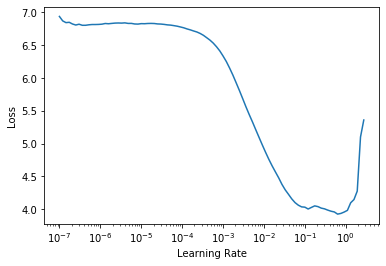

In [ ]:
learn.lr_find()

In [ ]:
#epochs are a bit longer due to the chosen melspectrogram settings
learn.fit_one_cycle(10, lr_max=slice(1e-2))

(#5) [0,1.9382734298706055,1.9040651321411133,0.48828125,00:12]
(#5) [1,0.8095316886901855,4.755290985107422,0.4518229067325592,00:11]
(#5) [2,0.4113352596759796,1.9035459756851196,0.6393229365348816,00:11]
(#5) [3,0.24505342543125153,1.2673859596252441,0.6497395634651184,00:11]
(#5) [4,0.14540395140647888,1.8934131860733032,0.65234375,00:11]
(#5) [5,0.10805315524339676,0.33648693561553955,0.91015625,00:11]
(#5) [6,0.07249930500984192,0.09889302402734756,0.9674479365348816,00:11]
(#5) [7,0.04562441259622574,0.012994271703064442,0.99609375,00:11]
(#5) [8,0.032863594591617584,0.019431808963418007,0.9908854365348816,00:11]
(#5) [9,0.02620488777756691,0.007657718379050493,0.9986979365348816,00:11]


# Training on 250 Speakers

## Baseline

In [ ]:
len(files_250)

44655

In [ ]:
for i in range(10):
    print(random.choice(files_250))

/home/jupyter/.fastai/data/250_speakers/250-speakers/id09068/FgsdnwUeLbQ/00034.wav
/home/jupyter/.fastai/data/250_speakers/250-speakers/id08931/VWkkyFseXq0/00093.wav
/home/jupyter/.fastai/data/250_speakers/250-speakers/id08925/bHZIObj5KRc/00072.wav
/home/jupyter/.fastai/data/250_speakers/250-speakers/id09193/oQ_wAYpETVo/00215.wav
/home/jupyter/.fastai/data/250_speakers/250-speakers/id09215/LL5rVd3_klU/00023.wav
/home/jupyter/.fastai/data/250_speakers/250-speakers/id09143/o0WYXM0AHSU/00053.wav
/home/jupyter/.fastai/data/250_speakers/250-speakers/id08938/Tza5wEVSwDg/00018.wav
/home/jupyter/.fastai/data/250_speakers/250-speakers/id09210/Krc8rw5hITI/00232.wav
/home/jupyter/.fastai/data/250_speakers/250-speakers/id09269/1-ycYhStJ4U/00042.wav
/home/jupyter/.fastai/data/250_speakers/250-speakers/id09226/dia1ew89HiQ/00053.wav


In [ ]:
#lens = stats(files_250)

In [ ]:
get_250speakers_label = lambda x: str(x).split('/')[-3][3:]

In [ ]:
for i in range(10):
    f = random.choice(files_250)
    print("File:",f )
    print("Label:", get_250speakers_label(f))

File: /home/jupyter/.fastai/data/250_speakers/250-speakers/id08890/39y4SHOk_XU/00021.wav
Label: 8890
File: /home/jupyter/.fastai/data/250_speakers/250-speakers/id08902/V8iO80JAlIA/00144.wav
Label: 8902
File: /home/jupyter/.fastai/data/250_speakers/250-speakers/id09155/jC9uOAwymcA/00223.wav
Label: 9155
File: /home/jupyter/.fastai/data/250_speakers/250-speakers/id08933/5zyBRP4EaSI/00057.wav
Label: 8933
File: /home/jupyter/.fastai/data/250_speakers/250-speakers/id09112/oFhWPmQ1M3Q/00072.wav
Label: 9112
File: /home/jupyter/.fastai/data/250_speakers/250-speakers/id08885/ymKY1RwnHR0/00476.wav
Label: 8885
File: /home/jupyter/.fastai/data/250_speakers/250-speakers/id08993/0BUR_R4VOD8/00010.wav
Label: 8993
File: /home/jupyter/.fastai/data/250_speakers/250-speakers/id09012/cH0KIzU7l4s/00077.wav
Label: 9012
File: /home/jupyter/.fastai/data/250_speakers/250-speakers/id09031/40lzCrU9WC4/00027.wav
Label: 9031
File: /home/jupyter/.fastai/data/250_speakers/250-speakers/id09193/Ow_zRKUyITc/00166.wav
La

In [ ]:
auds = DataBlock(blocks=(AudioBlock, CategoryBlock),  
                 get_items=get_audio_files, 
                 splitter=RandomSplitter(),
                 get_y=get_250speakers_label)

In [ ]:
dbunch250 = auds.databunch(p250speakers, item_tfms=tfms, bs=64)

In [ ]:
from fastprogress import progress_bar as pb


In [ ]:
cats = [y for _,y in pb(auds.datasource(p250speakers))]

In [ ]:
#verify categories are being correctly assigned for 250 speakers
test_eq(min(cats).item(), 0)
test_eq(max(cats).item(), 249)

In [ ]:
# Use torchaudio default MelSpectrogram to get a baseline
a2s = AudioToSpec()
crop_4000ms = CropSignal(4000)
tfms = [crop_4000ms, a2s]
dbunch = auds.databunch(p250speakers, item_tfms=tfms, bs=256)

In [ ]:
learn = Learner(dbunch, 
                xresnet18(),
                torch.nn.CrossEntropyLoss(), 
                metrics=[accuracy])
nchannels = dbunch.one_batch()[0].shape[1]
alter_learner(learn, nchannels)

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, lr_max=slice(2e-2))

In [ ]:
learn.lr_find()

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(5, lr_max=slice(1e-3))

## Customize our AudioToSpec Function using a config

In [ ]:
voice_cfg = AudioConfig.Voice()
a2s = AudioToSpec.from_cfg(voice_cfg)
tfms = [crop_4000ms, a2s]
# tfms = Pipeline([CropSignal(4000),  a2s, MaskFreq(size=12), MaskTime(size=15), SGRoll()], as_item=True)
dbunch = auds.databunch(p250speakers, item_tfms=tfms, bs=128)

In [ ]:
learn = Learner(dbunch, 
                xresnet18(),
                torch.nn.CrossEntropyLoss(), 
                metrics=[accuracy])
nchannels = dbunch.one_batch()[0].shape[1]
alter_learner(learn, nchannels)

In [ ]:
learn.lr_find()

In [ ]:
# Better results even without fine tuning, but much slower. We need to move a2s to the GPU and 
# then add data augmentation!
learn.fit_one_cycle(5, lr_max=slice(2e-2))

## Training an MFCC with Delta

In [ ]:
# only grab 1500ms of the clip, voice identity can be done with shorter sections and it will speed it up
# this is really slow for mfcc, even for 45k files, need to figure out what's going on here
a2mfcc = AudioToMFCC(n_mffc=20, melkwargs={"n_fft":2048, "hop_length":256, "n_mels":128})
tfms = [CropSignal(1500), a2mfcc, Delta()]
# tfms = Pipeline([CropSignal(4000),  a2s, MaskFreq(size=12), MaskTime(size=15), SGRoll()], as_item=True)
dbunch = auds.databunch(p250speakers, item_tfms=tfms, bs=1024)

In [ ]:
learn = Learner(dbunch, 
                xresnet18(),
                torch.nn.CrossEntropyLoss(), 
                metrics=[accuracy])

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(10, lr_max=slice(2e-2))

In [ ]:
learn.unfreeze()
learn.lr_find()

In [ ]:
learn.fit_one_cycle(7, lr_max=slice(3e-3, 4e-3))

<div class='alert alert-block alert-info'><strong>From Here:</strong><br>
    1. Get transforms on the GPU <br>
    2. Once it's faster test signal and spectrogram augments for speed/efficacy<br>
    3. Fine-tune and see how high we can push results on 250 speakers
</div>
